# Semantic Segmentation with the Masterful CLI Trainer

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_cli_semantic_segmentation.ipynb
[2]:https://docs.masterfulai.com/0.5.2/notebooks/guide_cli_semantic_segmentation.ipynb

In this guide, you will take a deeper look at Semantic Segmentation with the [Masterful CLI Trainer](../notebooks/tutorial_quickstart_cli.ipynb) to train a state of the art model. 

This guide will use the [Oxford Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset, which is a small dataset of cats and dogs with included segmentation masks.

## Define the Application

In this guide, your challenge is to build a CV model that can identify cats and dogs in an image. Importantly though, we want to classify, at a pixel level, where the animals are in the image. This is different than a standard classification task where you are only interested in the absence or presence of an animal, or a detection task where you only want a bounding box around the animal. Segmentation is an important task when the **shape** and **outline** of the object is important, such as detecting the presence of cancerous cells in a medical image. In this case, the shape of the cells is critical in determining whether or not the cells are cancerous, and providing the exact regions of interest at the pixel level can assist a medical examiner in understanding the diagnosis.

Since you want to identify each pixel in the image the CV task for this problem is **semantic segmentation**.

## TL;DR

Don't want to read the rest of this guide, and want to start training
immediately? The following command shows you how to start training
with Masterful, using a configuration file and dataset on S3.

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/training.yaml
```

## Prepare the Data

For this guide, you will use the [Oxford Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset, which is a dataset of cats and dogs used for image classification, object detection, and semantic segmentation. In this section, you will take the raw dataset and convert it into a format that Masterful can understand. Along the way, you will visualize a few examples of the data to see both the input to the model, as well as the predictions after training the model.

The original dataset can be downloaded from the above link. The dataset contains two separate `tar` files, the images and the annotations. The following is a description of the annotations from the README file in the download:  

```
We have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

Contents:
--------
trimaps/      Trimap annotations for every image in the dataset.
              Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/         Head bounding box annotations in PASCAL VOC Format
list.txt      Combined list of all images in the dataset
              Each entry in the file is of following nature:
              Image CLASS-ID SPECIES BREED ID
              ID: 1:37 Class ids
              SPECIES: 1:Cat 2:Dog
              BREED ID: 1-25:Cat 1:12:Dog
              All images with 1st letter as capital are cat images
              while images with small first letter are dog images.
trainval.txt  Files describing splits used in the paper. However,
test.txt      you are encouraged to try random splits.
```

The trimaps are single channel PNG images whose values are `1: Foreground 2:Background 3: Not classified`. The `Not classified` class corresponds to a border region around the `Foreground` class. Since you are building a binary segmentation model, you will treat the `Not classified` class as `Background`, leaving you with only two classes - `Background` (not cat or dog) and `Foreground` (cat or dog).

The Masterful CSV format for semantic segmentation consists of only two columns - the relative path to the image and the relative path to the segmentation mask. For example, below is a snippet of the CSV file used for training in this guide:  

```
data/Sphynx_158_train.jpeg,data/Sphynx_158_train_mask.png
data/english_cocker_spaniel_135_train.jpeg,data/english_cocker_spaniel_135_train_mask.png
data/British_Shorthair_181_train.jpeg,data/British_Shorthair_181_train_mask.png
data/Siamese_161_train.jpeg,data/Siamese_161_train_mask.png
data/Sphynx_178_train.jpeg,data/Sphynx_178_train_mask.png
.
.
.
```

Note that the segmentation masks are 0-indexed single channel PNGs. As part of the conversion process for this dataset, you should ensure that the two classes are labeled 0 and 1, rather than 1 and 2 as in the original trimaps. For clarity, the converted dataset below has 0 represent the `Background` and 1 represent `Foreground`.

You can read more about the semantic segmentation CSV format [here](../markdown/guide_cli_data_directory_format.md#semantic-segmentation).

Converting each dataset is typically a one-off operation that is different for every dataset you want to train with. For brevity, you can use the already converted dataset located at the public S3 bucket `s3://masterful-public/datasets/oxford_pets_binary_segmentation/`. In this bucket, you will see the following files:

```
oxford_pets_binary_segmentation\
  test.csv
  train.csv
  training.yaml
  label_map.csv
  data\
```

### Explore the Data

You should always visually inspect your dataset to get a sense of what the model will see, and to roughly verify that your dataset conversion routine worked properly and you are not training with corrupted or incorrect data. This is especially important for semantic segmentation since it is very easy to generate incorrect masks during dataset conversion.

In [3]:
# Install dependencies necessary to run the following
# code.
!pip install opencv-python-headless --quiet
!pip install masterful --quiet

# Import the packages used below.
import matplotlib.pyplot as plt
import os
import requests
import tarfile
import tempfile
import tensorflow as tf
import urllib.request

# Import and activate the Masterful package.
import masterful
masterful = masterful.activate()

# Helper function to display a progress when downloading
# a file using HTTP.
from masterful.utils.downloader import progress_bar_factory

# This is necessary for running inside of Colab/Jupyter,
# since the CLI trainer is run outside of the kernel
# (as a script command).
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.


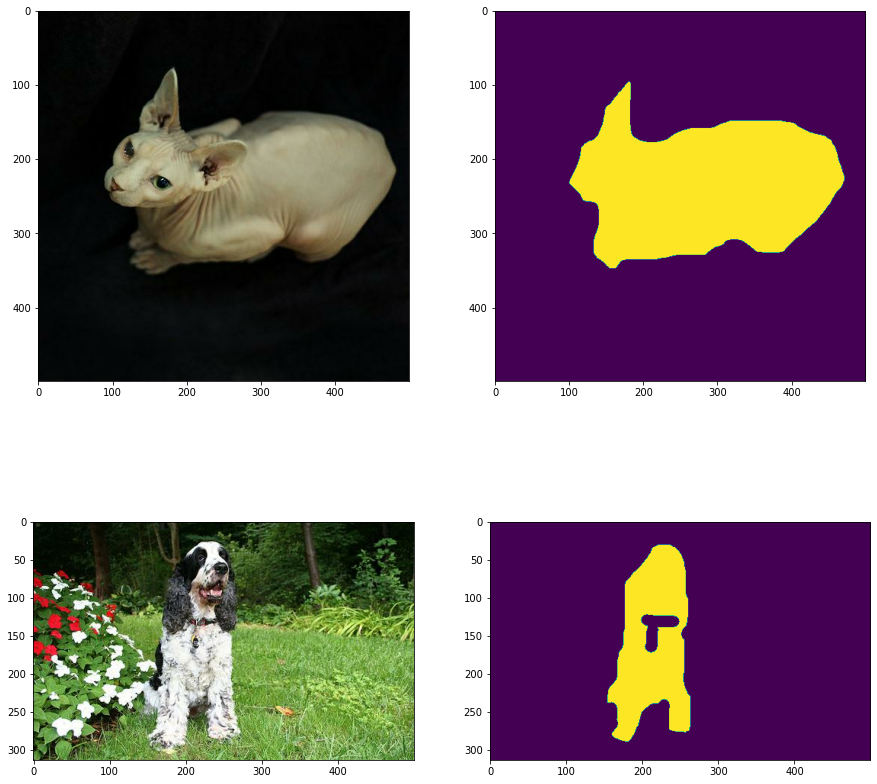

In [5]:
DATASET_ROOT = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/"
TRAINING_CSV_URL = os.path.join(DATASET_ROOT, "train.csv")

with tempfile.TemporaryDirectory() as temp_directory:
  training_csv_name = os.path.join(temp_directory, "train.csv") 
  _ =  urllib.request.urlretrieve(TRAINING_CSV_URL, training_csv_name)

  examples = []
  with open(training_csv_name) as training_csv:
    examples = training_csv.readlines()
  
image1_path, mask1_path = examples[0].split(',')
image2_path, mask2_path = examples[1].split(',')

image1 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image1_path))).read(), channels=3, dtype=tf.float32)
mask1 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, mask1_path))).read(), channels=1)
image2 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image2_path))).read(), channels=3,  dtype=tf.float32)
mask2 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, mask2_path))).read(), channels=1)

f, axarr = plt.subplots(2, 2, figsize=(15,15))
_ = axarr[0, 0].imshow(image1)
_ = axarr[0, 1].imshow(mask1)
_ = axarr[1, 0].imshow(image2)
_ = axarr[1, 1].imshow(mask2)


## Configure the CLI Trainer

The Masterful CLI Trainer is a command line tool that trains a production quality model with no code required. The Masterful CLI Trainer take a [YAML](../markdown/guide_cli_yaml_config.md) configuration file as input. The configuration file fully specifies everything necessary for training, including the dataset, model, export formats, and evaluation metrics.

### Choosing a Model

Masterful provides many different state of the art semantic segmentation models that you can choose from. In general, choosing a model can have different constraints than training the model (are you deploying on server or edge? Runtime or latency constraints? Memory constraints?). You generally want to choose a model that is large enough to fit your data, but not so large as to overfit the training data and "memorize" the results, which can lead to poor generalization performance.

The Masterful Semantic Segmentation Model Zoo supports the following model architectures.

| Model Name               | Year | Description                                                                                                                                                 |
|--------------------------|------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `unet_resnet50v1`        | 2015 | U-Net with ResNet-50 V1 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_resnet101v1`       | 2015 | U-Net with ResNet-101 V1 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)       |
| `unet_resnet152v1`       | 2015 | U-Net with ResNet-152 V1 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)       |
| `unet_efficientnetb0`    | 2015 | U-Net with EfficientNet-B0 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_efficientnetb1`    | 2015 | U-Net with EfficientNet-B1 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_efficientnetb2`    | 2015 | U-Net with EfficientNet-B2 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_efficientnetb3`    | 2015 | U-Net with EfficientNet-B3 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_efficientnetb4`    | 2015 | U-Net with EfficientNet-B4 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_efficientnetb5`    | 2015 | U-Net with EfficientNet-B5 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.045975)    |
| `unet_efficientnetb6`    | 2015 | U-Net with EfficientNet-B6 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_efficientnetb7`    | 2015 | U-Net with EfficientNet-B7 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)     |
| `unet_densenet121`       | 2015 | U-Net with DenseNet-121 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_densenet169`       | 2015 | U-Net with DenseNet-169 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_densenet201`       | 2015 | U-Net with DenseNet-201 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_inceptionresnetv2` | 2015 | U-Net with Inception ResNet V2 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) |
| `unet_inceptionv3`       | 2015 | U-Net with Inception V3 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_mobilenet`         | 2015 | U-Net with MobileNet backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)           |
| `unet_mobilenetv2`       | 2015 | U-Net with MobileNet V2 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_resnext50`         | 2015 | U-Net with ResNeXt-50 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)          |
| `unet_resnext101`        | 2015 | U-Net with ResNeXt-101 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)         |
| `unet_senet154`          | 2015 | U-Net with SE-Net-154 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)          |
| `unet_seresnet18`        | 2015 | U-Net with SE-ResNet-18 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_seresnet34`        | 2015 | U-Net with SE-ResNet-34 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_seresnet50`        | 2015 | U-Net with SE-ResNet-50 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)        |
| `unet_seresnet101`       | 2015 | U-Net with SE-ResNet-101 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)       |
| `unet_seresnet152`       | 2015 | U-Net with SE-ResNet-152 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)       |
| `unet_seresnext50`       | 2015 | U-Net with SE-ResNeXt-50 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)       |
| `unet_seresnext101`      | 2015 | U-Net with SE-ResNeXt-101 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)      |
| `unet_vgg16`             | 2015 | U-Net with VGG-16 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)              |
| `unet_vgg19`             | 2015 | U-Net with VGG-19 backbone, from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)              |

### The Configuration File

The following section is a condensed YAML configuration file for training against this dataset with **NO** unlabeled data. It points to the dataset created above, and selects a `unet_resnet50v1` model, which is a good general model to start with on segmentation tasks. You will train at an input resolution of `320x320`, so make sure to run on an instance with sufficient GPU memory to support this resolution. The input resolution for semantic segmentation has a large impact on the amount of GPU memory required for training, so if you run into out of memory errors, try training on a larger instance or reducing the input resolution to a more manageable size. 

Note all of the model artifacts will be saved to the directory `~/model_output`, which you can configure in the `output` section below.

The original YAML file can be found [here](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/training.yaml).

```yaml
dataset:
  root_path: 'https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation'
  splits: [train, test]
  label_map: label_map
  optimize: True
  label_format: segmentation_csv
model:
  architecture: unet_resnet50v1
  num_classes: 1
  input_shape: [320,320,3]
training:
  task: semantic_segmentation
  training_split: train
output:
  formats: [saved_model, onnx]
  path: ~/model_output
evaluation:
  split: test
```

## Train the Model

Training the model involves simply running the Masterful CLI Trainer (`masterful-train`) against the YAML file on S3. 
Below, you will setup the CLI and configuration file to run in this notebook. However, if you want to train this model outside of the notebook, against the dataset on S3, you can run:

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/training.yaml
```

NOTE: Semantic segmentation models are quite large. Depending on your GPU, this could take several hours to complete, so plan accordingly.

In [39]:
# Use the Masterful CLI to train the model without unlabeled data
!masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/training.yaml

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.
MASTERFUL [13:09:48]: Training with configuration 'https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/training.yaml':
----------  ----------------------------------------------------------------------------------------------------------
dataset     root_path     https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation
            splits        ['train', 'test']
            label_map     label_map
            optimize      True
            label_format  segmentation_csv
model       architecture  unet_resnet50v1
            num_classes   1
            input_shape   [320, 320, 3]
training    task            semantic_segmentation
            training_split  train
output      formats  ['saved_model', 'onnx']
            path     ~/model_output
evaluation  split  test
----------  ----------------------------------------------------

## Analyze the Results

At the end of training, Masterful will evaluate your model based on the test (sometimes called holdout) dataset you specified in the `evaluation` section of your configuration file. The evaluation results are different for each task, since every computer vision task has both general metrics (such as loss) as well as task-specific metrics (IoU for semantic segmentation for example). These results are printed to the console, as well as saved into a CSV file in the output directory specified in your configuration file.

### Semantic Segmentation Evaluation Metrics

For Semantic Segmentation, Masterful reports two main categories of metrics: Model Loss and Intersection over Union.

#### Model Loss

The first set of metrics Masterful reports is the overall loss of the model. For semantic segmentation models, Masterful reports the total loss as well as any sub-losses that are specific to the model architecture. Different models have different sub-losses, and you can gauge how your model is doing on the different tasks based on the final results of these sub-metrics.

The following is the loss results from the above training run (this might be different if you rerun the above cells):  

```
MASTERFUL [20:02:29]: Evaluating model on 3669 examples from the 'test' dataset split:
Evaluating: 100%|██████████████████████████| 3669/3669 [00:13<00:00, 273.79it/s]
MASTERFUL [20:02:43]:   Loss: 0.0677
MASTERFUL [20:02:43]:   Binary Accuracy: 0.9740
```

As you can see in the above output, the total loss of the model is `MASTERFUL [20:02:43]:   Loss: 0.0677`. Masterful also reports the per-pixel accuracy of the mask prediction `MASTERFUL [20:02:43]:   Binary Accuracy: 0.9740`. An accuracy of 97.4% seems really good! However, with semantic segmentation you need to be careful when looking at overall accuracy, since its is a heavily imbalanced task. For example, let's say your image contains 100 pixels, and only 5 of those pixels represent the foreground object to predict. A model that predicted all background pixels would be 95% accurate, even though it never makes a correct prediction for the pixels you care about. Therefore, it's really difficult to understand intuitively what this means in terms of your models overall performance. Are these good values? Or bad ones? Let's dive into the rest of the metrics to answer these questions.

**Quick Aside**: It is possible to use the accuracy results to quantify the performance of your model, but first you must understand the per-pixel distribution of classes in the evaluation data. For example, if the distribution of classes is roughly balanced on a pixel level, then the accuracy indicator will be a good indicator of the predictive performance of your model. But how do we know the per-pixel label distribution of our training and evaluation data? Masterful will tell you this in the dataset analysis section. Below is the snippet from the `Test Dataset Analysis` performed at the start of training:  

```
Label Distribution (Per Pixel)  Background  0.701462
                                Foreground  0.298538
```

In this example, a biased model that predicted all background would be correct only 70% of the time, and an unbiased random model would be correct 50% of the time. So based on a binary accuracy of 97.4%, it is safe to assume your model has both not collapsed to a single prediction and is doing better than random. So it is likely that your model is performing well. So next you will take a closer look and verify those results.

#### Intersection over Union

Intersection over Union is a measure of overlap between two regions. Formally, it is defined as:

![IoU](../images/iou_def.png)
![IoU Boxes](../images/iou.jpeg)

Intesection over Union is a helpful metric because it can tell you how close the predicted masks match the groundtruth data. For example, in the 100 pixel example above, if the model predicted all background class, the IoU on the foreground class would be 0, because there would be no overlap between the predicted mask and the groundtruth data.

Below is the average IoU and the per-class IoU metrics for the training run above:  

```
IoU: 100%|████████████████████████████████████| 230/230 [00:23<00:00,  9.59it/s]
MASTERFUL [20:03:07]:   Average Intersection over Union:    0.9298
MASTERFUL [20:03:07]: 
MASTERFUL [20:03:07]:   Per-Class Metrics:
MASTERFUL [20:03:07]:     Class Background:
MASTERFUL [20:03:07]:       Intersection over Union: 0.9678
MASTERFUL [20:03:07]:     Class Foreground:
MASTERFUL [20:03:07]:       Intersection over Union: 0.8918
```

As you can see from both the average IoU (`Average Intersection over Union:    0.9298`) and the per-class IoU, the model is performing pretty well on predicting the segmentation masks.

### View the Predictions

While the IoU metrics are a good quantitative indicator of the performance of your model, visualizing the predictions can help you get a qualititative sense of how well your trained model is performing. Below you can see the predictions for the above trained model on the examples you visualized above.

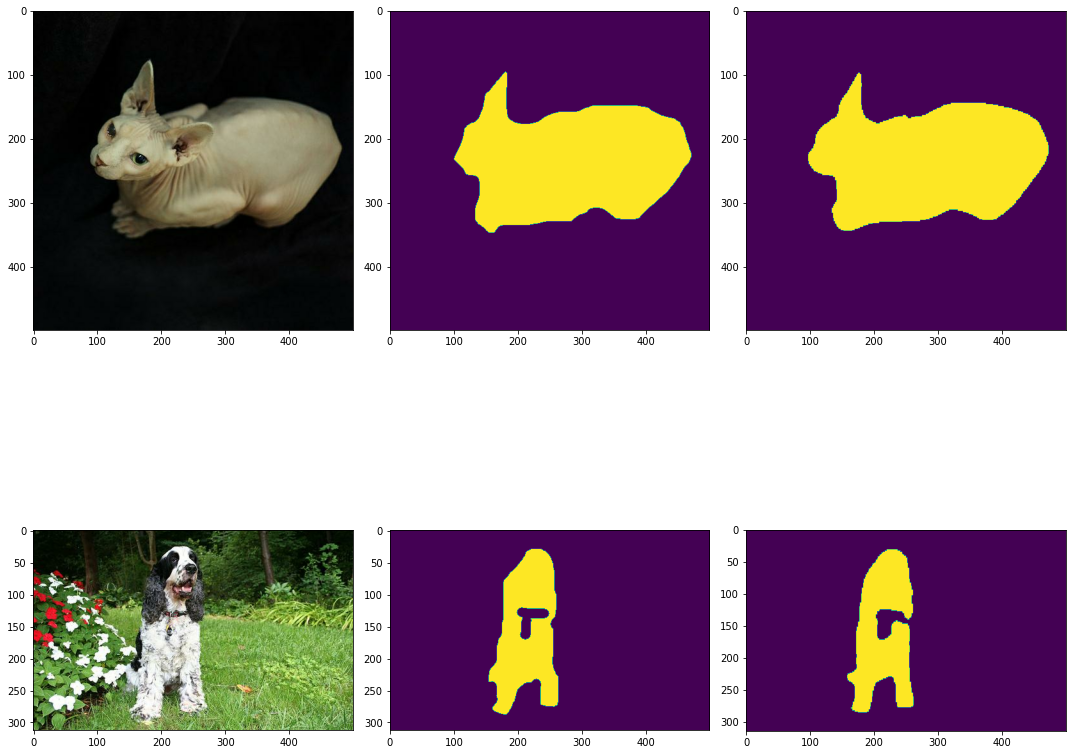

In [10]:
import numpy as np

# Download the pretrained model so that you can
# visualize the results.
MODEL_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/oxford_pets_binary_segmentation/trained_model.tar.gz"

model = None
with tempfile.TemporaryDirectory() as temp_directory:
  # Download the pretrained model from S3.
  saved_model_path = os.path.join(temp_directory, "saved_model.tar.gz") 
  _ =  urllib.request.urlretrieve(MODEL_URL, saved_model_path, progress_bar_factory("Downloading Model: "))

  # Extract the model weights from the tar file.
  with tarfile.open(saved_model_path) as tar:
    tar.extractall(temp_directory)
  saved_model_path = os.path.join(temp_directory, "saved_model") 

  # Load the trained tensorflow saved model.
  model = tf.saved_model.load(saved_model_path)
  
  image1_path, mask1_path = examples[0].split(',')
  image2_path, mask2_path = examples[1].split(',')

  image1 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image1_path))).read(), channels=3, dtype=tf.uint8)
  mask1 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, mask1_path))).read(), channels=1)
  image2 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image2_path))).read(), channels=3,  dtype=tf.uint8)
  mask2 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, mask2_path))).read(), channels=1)

  # The default inference function for tensorflow saved
  # models is named `serving_default`.
  inference_fn = model.signatures["serving_default"]

  # The inference function is a one-arg callable, whose
  # input argument is `image` - the image to predict on,
  # and which returns a dictionary of outputs. The dictionary
  # contains an item whose key is `prediction`, which is the
  # predictions of the model.
  image1_predictions = inference_fn(image=image1)['prediction']
  image2_predictions = inference_fn(image=image2)['prediction']

  # Threshold the predictions to determine the class prediction
  image1_predictions = np.where(image1_predictions.numpy() >= 0.5, np.ones_like(image1_predictions), np.zeros_like(image1_predictions))
  image2_predictions = np.where(image2_predictions.numpy() >= 0.5, np.ones_like(image2_predictions), np.zeros_like(image2_predictions))

# Plot a few different instances from the dataset.
f, axarr = plt.subplots(2, 3, figsize=(15,15))
_ = axarr[0, 0].imshow(image1)
_ = axarr[0, 1].imshow(mask1)
_ = axarr[0, 2].imshow(image1_predictions)
_ = axarr[1, 0].imshow(image2)
_ = axarr[1, 1].imshow(mask2)
_ = axarr[1, 2].imshow(image2_predictions)
f.tight_layout()

As you can see above, the predicted masks are quite accurate and represent a well-trained model.

## Using the Model for Inference

The [Output Formats](../markdown/guide_cli_model_output_formats.md) guide has more information about how to use the models output by Masterful. Semantic Segmentation has a few other intricacies that should be addressed though, since the model outputs a prediction for every pixel in the input image. Above, you used the trained model to generate predictions, and view the predictions side by side with the ground truth label. The predictions are floating point values in the range `[0, 1]`, so it's important to convert these into discrete class predictions. Since this is a binary prediction task, you can do this with a basic threshold. Below you can see the snippets from above that handled making predictions and thresholding those predictions for accurate per-pixel class predictions.

```python
# Load the trained tensorflow saved model.
model = tf.saved_model.load(saved_model_path)

# The default inference function for tensorflow saved
# models is named `serving_default`.
inference_fn = model.signatures["serving_default"]

# The inference function is a one-arg callable, whose
# input argument is `image` - the image to predict on,
# and which returns a dictionary of outputs. The dictionary
# contains an item whose key is `prediction`, which is the
# predictions of the model.
image1_predictions = inference_fn(image=image1)['prediction']
image2_predictions = inference_fn(image=image2)['prediction']

# Threshold the predictions to determine the class prediction
image1_predictions = np.where(image1_predictions.numpy() >= 0.5, 
                              np.ones_like(image1_predictions), 
                              np.zeros_like(image1_predictions))
image2_predictions = np.where(image2_predictions.numpy() >= 0.5, 
                              np.ones_like(image2_predictions), 
                              np.zeros_like(image2_predictions))
```

## Next Steps

In the above sections, you have learned how to train a semantic segmentation model using the Masterful CLI, evaluate the performance of the model, and use the model to make predictions on your production data.

If you want to look at other use cases, you will find an [Object Detection](../notebooks/guide_cli_digit_detection.ipynb) guide as well a more advanced Object Detection example, [Detecting Pedestrians in Street Level Imagery](../notebooks/guide_cli_object_detection_pedestrians.ipynb). Otherwise, feel free to explore [Classifying Land Use](../notebooks/guide_cli_classification_land_use.ipynb) for other examples of using the Masterful CLI Trainer to solve challenging computer vision problems.